# Importing libraries

In [30]:
import pandas as pd # used for dataframes
import numpy as np 
import xgboost as xgb # Gradient Boosting Algorithm
import matplotlib.pyplot as plt
import seaborn as sns
import gc # Garbage Collector required to extract unused and residual data and variables from memory
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline

# Importing part of train_dataset (all models are based on the original dataset)

In [28]:
df = pd.read_csv('/Users/azin/code/azinmjalali/ChangeDEEPly/raw_data/df_featured.csv')

In [29]:
df.head()

,Unnamed: 0,user_course_id,truth,female,male,age,Associate,Bachelor's,Doctorate,High,...,pause_video,play_video,problem_check,problem_check_correct,problem_check_incorrect,problem_get,problem_save,reset_problem,seek_video,stop_video
0,0,1000607_1926,0,0.0,1.0,-0.08537,0.0,0.0,0.0,0.0,...,0.025980,-0.306546,-0.307915,-0.339353,-0.238328,-0.056653,-0.188241,-0.114953,-0.243711,-0.050669
1,1,1000607_2070,0,0.0,1.0,-0.08537,0.0,0.0,0.0,0.0,...,-0.327739,-0.306546,-0.307915,-0.339353,-0.238328,-0.056653,-0.188241,-0.114953,-0.243711,-0.050669
2,2,1000607_2909,0,0.0,1.0,-0.08537,0.0,0.0,0.0,0.0,...,0.094442,-0.306546,-0.307915,-0.339353,-0.238328,-0.027710,-0.188241,-0.114953,-0.243711,-0.050669
3,3,1000607_536,0,0.0,1.0,-0.08537,0.0,0.0,0.0,0.0,...,-0.008251,0.312685,-0.176667,-0.130004,-0.238328,0.007021,0.541546,-0.114953,2.138872,-0.042257
4,4,1000607_747,0,0.0,1.0,-0.08537,0.0,0.0,0.0,0.0,...,-0.031071,0.288401,-0.307915,-0.339353,-0.238328,-0.056653,-0.188241,-0.114953,-0.022075,-0.020386


In [20]:
X = df.drop(columns = ['Unnamed: 0', 'truth','user_course_id', ])
y = df['truth']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [2]:
train_df = pd.read_csv('/Users/azin/code/azinmjalali/ChangeDEEPly/raw_data/test/test.csv', nrows = 1894486)

In [3]:
train_df.head(2)

,enroll_id,username,course_id,session_id,action,object,time,truth
0,775,1520977,course-v1:TsinghuaX+70800232X+2015_T2,5f421f644193c2d48c84df42aaf7e48b,load_video,3dac5590435e43b3a65a9ae7426c16db,2015-10-15T22:14:11,1
1,775,1520977,course-v1:TsinghuaX+70800232X+2015_T2,5f421f644193c2d48c84df42aaf7e48b,load_video,3169d758ee2d4262b07f0113df743c42,2015-10-15T22:43:35,1


# Data cleaning 

In [4]:
train_df = train_df.drop(['enroll_id','object'],axis =1)

In [5]:
train_df.head(2)

,username,course_id,session_id,action,time,truth
0,1520977,course-v1:TsinghuaX+70800232X+2015_T2,5f421f644193c2d48c84df42aaf7e48b,load_video,2015-10-15T22:14:11,1
1,1520977,course-v1:TsinghuaX+70800232X+2015_T2,5f421f644193c2d48c84df42aaf7e48b,load_video,2015-10-15T22:43:35,1


# Feature engineering 

## Creating time_diff columns based on the time spent by users per each activity

In [6]:
train_df['Datetime'] = pd.to_datetime(train_df['time'])
train_df = train_df.drop(['time'], axis = 1)

In [7]:
# convert datetime to timestamp 
train_df['timestamp'] = train_df.Datetime.values.astype(np.int64) // 10 ** 9
train_df = train_df.drop(['Datetime'], axis = 1)

In [8]:
train_df = train_df.sort_values(['username', 'session_id','timestamp'])
train_df['timediff'] = pd.DataFrame(train_df.groupby('username').timestamp.diff().fillna(0))

## converting action column to numerical columns (OneHot encoding)

In [9]:
train_df['action'].unique()

array(['click_info', 'click_courseware', 'close_courseware',
       'click_about', 'load_video', 'pause_video', 'play_video',
       'problem_get', 'problem_check', 'problem_check_incorrect',
       'problem_check_correct', 'stop_video', 'seek_video', 'click_forum',
       'create_comment', 'reset_problem', 'click_progress',
       'problem_save', 'delete_comment', 'create_thread', 'delete_thread'],
      dtype=object)

In [10]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse = False) 

ohe.fit(train_df[['action']]) 

action_encoded = ohe.transform(train_df[['action']]) 

train_df['click_info'], train_df['click_courseware'], train_df['close_courseware'], train_df['click_about'],train_df['load_video'],\
train_df['pause_video'], train_df['play_video'], train_df['problem_get'], train_df['problem_check'], train_df['problem_check_incorrect'], train_df['problem_check_correct'],\
train_df['stop_video'], train_df['seek_video'], train_df['click_forum'], train_df['create_comment'],\
train_df['reset_problem'], train_df['click_progress'], train_df['problem_save'],\
train_df['delete_comment'], train_df['create_thread'], train_df['delete_thread'] = action_encoded.T


In [11]:
train_df[].head()

,username,course_id,session_id,action,truth,timestamp,timediff,click_info,click_courseware,close_courseware,...,stop_video,seek_video,click_forum,create_comment,reset_problem,click_progress,problem_save,delete_comment,create_thread,delete_thread
1822396,5,course-v1:UQx+Crime101x+_,0acd40efd56d6ef6de638a50184b1910,click_info,1,1458657513,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1822397,5,course-v1:UQx+Crime101x+_,0acd40efd56d6ef6de638a50184b1910,click_info,1,1458657515,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1822398,5,course-v1:UQx+Crime101x+_,0acd40efd56d6ef6de638a50184b1910,click_courseware,1,1458657517,2.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1822399,5,course-v1:UQx+Crime101x+_,0acd40efd56d6ef6de638a50184b1910,click_courseware,1,1458658238,721.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1822400,5,course-v1:UQx+Crime101x+_,0acd40efd56d6ef6de638a50184b1910,click_courseware,1,1458658239,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Preprocessing 

## Scaling 

In [23]:
from sklearn.ensemble import GradientBoostingClassifier

In [24]:
train_df.head(2)

,username,course_id,session_id,action,truth,timestamp,timediff,click_info,click_courseware,close_courseware,...,stop_video,seek_video,click_forum,create_comment,reset_problem,click_progress,problem_save,delete_comment,create_thread,delete_thread
1822396,5,course-v1:UQx+Crime101x+_,0acd40efd56d6ef6de638a50184b1910,click_info,1,1458657513,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1822397,5,course-v1:UQx+Crime101x+_,0acd40efd56d6ef6de638a50184b1910,click_info,1,1458657515,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Modeling

In [25]:
train_df = train_df.set_index(['username', 'course_id'])

In [26]:
X = train_df.drop(columns = ['session_id',  'action', 'truth', "timestamp"])

In [27]:
y = train_df['truth']

In [28]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
X_scaled = std_scaler.fit_transform(X)

## GradientBoostingClassifier

In [7]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

gbc_model = GradientBoostingClassifier()
cv_re
gbc_model.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [8]:
gbc_model.predict(X_test)

array([1, 1, 1, ..., 1, 0, 1])

In [ ]:
gbc

## XGBClassifier

In [31]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
xgbc_model = XGBClassifier(tree_method = 'gpu_hist'  # THE MAGICAL PARAMETER THAT INTEGRATES KAGGLE'S GPU ACCELERATED KERNEL
)
xgbc_model.fit(X_scaled, y)

/Users/azin/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:36:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='binary:logistic',
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=True, validate_parameters=1, verbosity=None)

## KNN

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y,
                                                    test_size=0.30)

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

In [19]:
y_train.head()

4545     1
19042    0
5006     1
6694     1
31227    1
Name: truth, dtype: int64

In [24]:
knn = KNeighborsClassifier()
cross_val_score(knn, X_train, y_train, cv = 5 , scoring= 'accuracy').mean()


0.801204327346202

In [ ]:
cros

In [ ]:
### To check which number is the best for neighbors !

In [25]:
error_rate = []

# Will take some time
for i in range(1,40):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Error Rate')

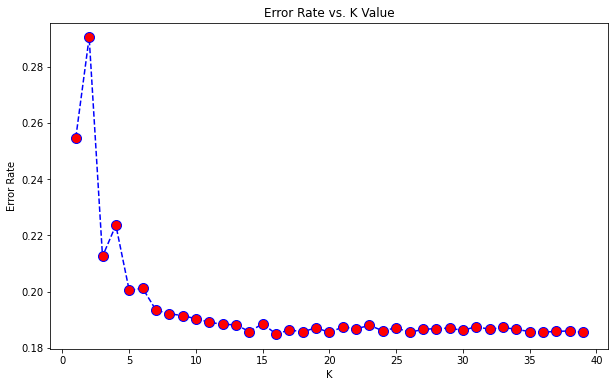

In [26]:
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

# Setting up pipeline

In [ ]:
from sklearn.pipeline import Pipeline
models = [gbc_model, xgbc_model, knn]

def set_pipeline(self):
    """defines the pipeline as a class attribute"""
    for model in models:
        
        self.pipeline = Pipeline([
            ('preproc', preproc_pipe),
            ('f{model}', model)
            ])

# Checking the accuracy of the model by evaluating on test dataset

## Importing test dataset

## Data cleaning

## New features

## Preprocessing

## Defining X_test and y_test

## Modeling

## Checking the performance metrics